## Functions 

In [1]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


### Helper functions

In [ ]:
# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }



### Transition functions

#### Original no people added

In [13]:
# Updated transition model based on matched organs
def transition(state, action, sample_urgency_func):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        allocate[group_id] = 0 
        for _ in range(patients_per_group[group_id+1]):
            urgency = sample_urgency_func(group_id) 
            if urgency > priority:
                allocate[group_id] += 1 #get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if new_state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward

#### People get added

In [255]:
def transition_add(state, action, sample_urgency_func):
    allocate = {}
    urgency_levels = []
    reward = 0  # Start reward as 0
 
    
    # Allocate organs based on action and urgency
    for group_id, priority in enumerate(action):
        allocate[group_id] = 0
        for _ in range(patients_per_group[group_id + 1]):
            urgency = sample_urgency_func(group_id)
            urgency_levels.append(urgency)
            if urgency > priority:
                allocate[group_id] += 1  # Organ is matched to a patient
    
    # Create the new state
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organs
        "urgency_levels": urgency_levels,  # Update urgency levels
        "patient_groups": [],
    }

    # Update patient group sizes and matched organs
    reward += sum(urgency_levels[:sum(allocate.values())]) * 0.5  # Match urgency
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        new_patients = np.random.poisson(lam=group_lambdas[group_id])
        #Penalty for overallocation
        patients_per_group[group_id + 1] += new_patients #Add new
        patients_per_group[group_id + 1] -= matched_organs #Remove matched
        #patients_per_group[group_id + 1] = max(0, patients_per_group[group_id + 1]) #Ensure don't get negative

        # Reward for allocating organs to patients
        reward += matched_organs * (5 + group_id)  # Add weight to group priority


    reward -= 10 * patients_per_group[3] if patients_per_group[3] > 0 and allocate[2] == 0 else 0  # Lower penalty
    reward -= 200 if new_state["organs"] == 0 and new_state["time"] < time_horizon else 0

    if episode > 1 and rewards_per_episode[-1] > rewards_per_episode[-2]:
        reward += 10 

    return new_state, reward

### Sampling distributions

In [14]:

# Define urgency sampling function
def sample_urgency_beta(group_id):
    #Beta params
    alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
    beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

In [ ]:
# Sample urgency using Meld
# Define urgency sampling function
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408} #exp

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency_meld(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=3)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=3, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

### Extract optimal policy

In [16]:
# Function to extract the optimal policy from the Q-table
def extract_optimal_policy(Q_table):
    optimal_policy = {}
    for state, actions in Q_table.items():
        optimal_action = max(actions, key=actions.get)  # Action with the highest Q-value
        optimal_policy[state] = optimal_action
    return optimal_policy

# Function to simulate the process using the optimal policy
def simulate_with_optimal_policy(optimal_policy, transition_func, sample_urgency_func):
    state = initialize_state()  # Start from the initial state
    organs_allocated_over_time = []  # Track cumulative allocations

    for t in range(time_horizon):
        key = state_to_key(state)  # Get state key

        # Get the action from the optimal policy
        if key in optimal_policy:
            action = optimal_policy[key]
        else:
            action = random.choice(actions)  # Fallback to a random action if state not in policy

        # Simulate environment
        next_state, _ = transition_func(state, action, sample_urgency_func)

        # Track total organs allocated so far
        allocated = total_organs - next_state["organs"]
        organs_allocated_over_time.append(allocated)

        # Update state
        state = next_state

        if state['organs'] <= 0:
            break

    return organs_allocated_over_time

### Q-learning loop

In [251]:
def Q_learn(transition_func, sample_func, num_episodes, alpha, gamma, epsilon):
    # Initialize Q-table dynamically
    def initialize_Q(state):
        key = state_to_key(state)
        if key not in Q_table:
            Q_table[key] = {a: 0 for a in actions}
            
    # Action space: Prioritization levels for all groups (bounded [0, 10])
    actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

    # Q-table
    Q_table = {}
    def initialize_Q(state):
        key = state_to_key(state)  # Convert state to key
        if key not in Q_table:
            Q_table[key] = {a: 1 for a in actions}  # Optimistic initialization


    rewards_per_episode = []

    for episode in range(num_episodes):
        if episode % 500 == 0:
            print(f"Episode {episode+1}/{num_episodes}")
        state = initialize_state()  # Start from the initial state
        total_reward = 0

        for t in range(time_horizon):
            # Convert state to key and initialize Q-table entry if needed
            #print(state)
            key = state_to_key(state)
            initialize_Q(state)

            # Choose an action (epsilon-greedy policy)
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)  # Explore
            else:
                action = max(Q_table[key], key=Q_table[key].get)  # Exploit
                
            #print(f"action is {action}")

            # Simulate environment
            next_state, reward = transition_func(state, action, sample_func)
            next_key = state_to_key(next_state)
            initialize_Q(next_state)  # Initialize next state in Q-table if needed

            # Update Q-value using the Bellman equation
            best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
            Q_table[key][action] += alpha * (
                reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
            )
            #print(Q_table[next_key][best_next_action])

            state = next_state
            total_reward += reward
            
            if state['organs'] <= 0: 
                #print("used up all the organs")
                break

        rewards_per_episode.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)  # Decay epsilon
        #if episode > 100 and rewards_per_episode[-1] < np.mean(rewards_per_episode[-50:]):
           # epsilon = min(0.2, epsilon + 0.05)  # Mild exploration boost if rewards stagnate
        
        alpha = max(0.1, alpha * 0.995)
    return Q_table, rewards_per_episode

### Plots

In [250]:
def plot_cumulative(rewards_per_episode, title):
    # Plot cumulative rewards per episode
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    plt.plot(rewards_per_episode)

    plt.title("Cumulative Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.savefig(f"{title}.png")
    plt.show()

def plot_average(rewards_per_episode, title):
    # Visualize the results
    window = 20  # Moving average window
    avg_rewards = [
        np.mean(rewards_per_episode[i : i + window])
        for i in range(len(rewards_per_episode) - window)
    ]
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
    plt.plot(avg_rewards, label = 'v')
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    plt.title("Average Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.savefig(f"{title}.png")
    plt.show()

def plot_organs_allocated(Q_table, transition_func, sample_func, title):
    # Extract optimal policy
    optimal_policy = extract_optimal_policy(Q_table)

    # Simulate using the optimal policy
    organs_allocated = simulate_with_optimal_policy(optimal_policy, transition_func, sample_func)

    # Plot total organs allocated over time
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label='Organs Allocated')

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')

    plt.xlim(0)  
    plt.ylim(0)
    plt.title("Organs Allocated Over Time Using the Optimal Policy")
    plt.xlabel("Time Steps")
    plt.ylabel("Total Organs Allocated")
    plt.savefig(f"{title}.png")

    plt.show()

## Single Decision Maker (UNOS) Q-Learning

## Single Decision Maker - Beta
One patient per group

{1: 2, 2: 5, 3: 1}
Episode 1/500
{1: 4, 2: 2, 3: 1}


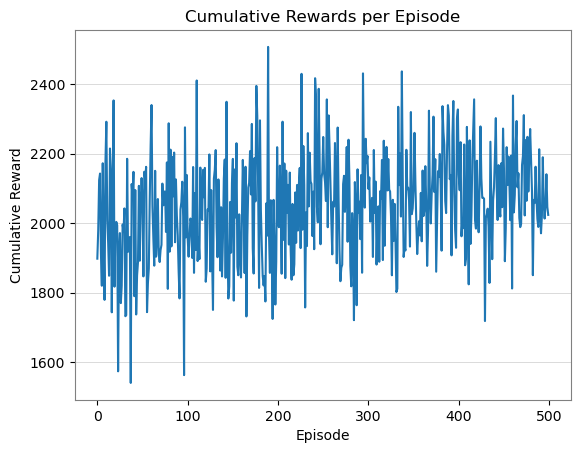

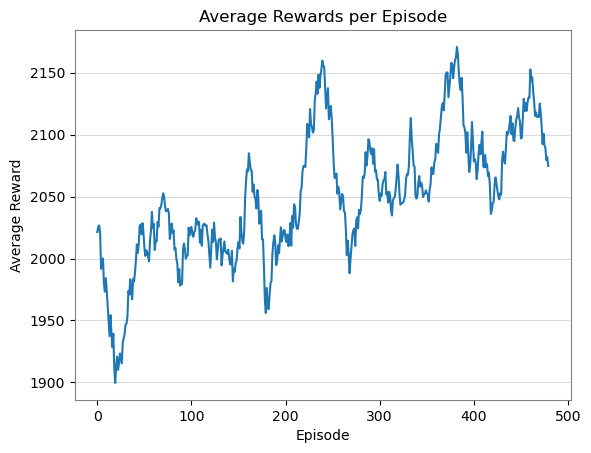

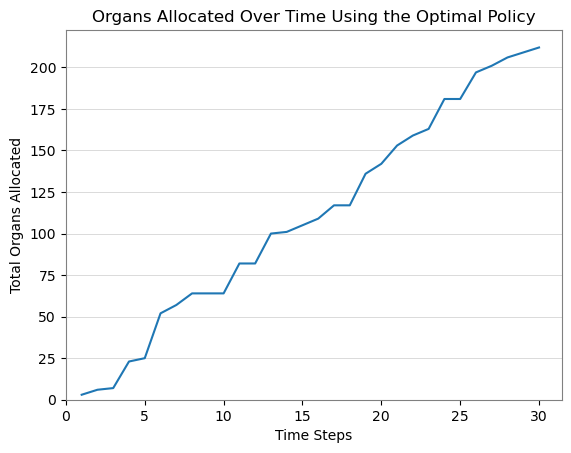

In [ ]:
# Parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 500 # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1 }
group_lambdas = [2, 5, 1] 


epsilon = 0.8
alpha = 0.4
gamma = 0.99

#params for when ppl get added
epsilon = 0.8
alpha = 0.6
gamma = 1 #this absolutely needs to be 1

transition_func = transition_add
sample_func = sample_urgency_meld
print(patients_per_group)

Q_table, rewards_per_episode = Q_learn(transition_func, sample_func, num_episodes, alpha, gamma, epsilon)

print(patients_per_group)


plot_cumulative(rewards_per_episode, "y")
plot_average(rewards_per_episode, "y")
plot_organs_allocated(Q_table, transition_func, sample_func, "z")
